In [467]:
%load_ext autoreload
%autoreload 2


import os
import sys 
print(sys.executable)

os.chdir("/Users/niel.hu/research/TrainingDynamics")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/niel.hu/research/env/bin/python3.7


In [468]:
import uuid 
id = uuid.uuid4().hex
id

'f1b24f0b9fc64fef903312bd53d7b47d'

In [469]:
'''try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle'''
    
    
import pickle as pickle

    
import torchvision.transforms as transforms
from utils.mnist import IndexedMNIST as mnist
from utils.cifar import IndexedCifar10 as cifar10

import matplotlib.pyplot as plt
import numpy as np
import pdb
import torch

import seaborn as sns
import time
import pandas as pd


from IPython.display import clear_output

In [547]:

import pickle5 as pickle








directories = [
    "result-noisymnist-standard",
    "result-noisymnist-rand",
    "result-noisymnist-beta1",
    "result-noisymnist-beta1-upweight"
    ]

directories = [
    "result-standard",
    "result-beta3-loss",
    "result-beta3-loss-upweight",
    "result-beta3-loss-upweight-floored"
    ]

directories = [
    "gaussian_standard",
    "gaussian_standard_SB1",
    #"gaussian_standard_USB3",
    #"gaussian_standard_SB3",
    #"gaussian_standard_USB3"
    ]

def load_blobs(files, blob_type="train"):
    start = time.time()
    blob_runs = []
    for count, file in enumerate(files):

        print ("Progress: {:0.2f} %, {} Seconds ".format((count + 1)/len(files) * 100, time.time() - start))
        clear_output(wait=True)
        with open(file + "/{}-log.txt.logger.blob.pickle".format(blob_type), 'rb') as handle:
            run = pickle.load(handle)
        blob_runs.append(run)
    return blob_runs


results = {}

for dname in directories:
    #d =   "cifar10/noisy_cifar10/" + dname
    #d = "mnist/" + dname
    d = dname
    #dir_name = d + "_stats"
    #files = [os.path.join(d, file)  for file in os.listdir(d) if "result" in file] #startswith("result-")][:5]
    results[dname] = {"train": load_blobs([d]), "test":load_blobs([d], "test")}


Progress: 100.00 %, 8.106231689453125e-06 Seconds 


In [519]:




# cifar
pct0 = np.load("dataset_overrides/cifar10/0pct_random_label.npy")
pct25 = np.load("dataset_overrides/cifar10/25pct_random_label.npy")
noise = set(np.array(range(len(pct0)))[pct0 != pct25])


# mnist
pct0 = np.load("dataset_overrides/mnist/0pct_random_label.npy")
pct75 = np.load("dataset_overrides/mnist/75pct_random_label.npy")

pct50_example_to_add_noise = np.load("dataset_overrides/mnist/50pct_example_to_add_noise.npy")

#noise = set(np.array(range(len(pct0)))[pct0 != pct75])


noise = set(pct50_example_to_add_noise)


In [71]:
#[j for j in results[dname]['train'][0]['train_loss']]

#buf = results["result-beta1-loss-upweight"]['train'][0]['examples'][1][70]
#plt.hist([k[1] for k in buf], bins=64)

buf = []
for i in results["result-standard"]['train'][0]['examples']:
    for j in i:
        buf += [np.mean([k[1] for k in j])]


In [526]:

def merge(data, multipliers=None):
    ret = []
    for epoch_idx, epoch in enumerate(data['examples']):
        epoch_buf = []
        
        for iteration_idx, iteration in enumerate(epoch):
            
            try:
                buf = data['multipliers'][epoch_idx][iteration_idx]
            except:
                buf = [1] * len(iteration)
            #buf = [1] * len(iteration)
            epoch_buf += [list(zip([i[0] for i in iteration], [i[1] for i in iteration],  buf))]
        
        ret += [epoch_buf]
    return ret



In [524]:
#results['result-beta3-loss-upweight-floored']['train'][0]['multipliers']

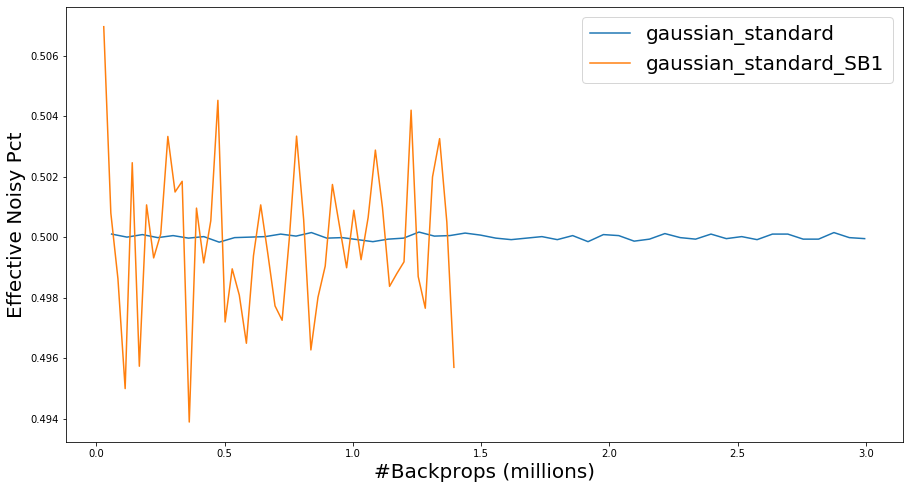

In [548]:
fig, ax = plt.subplots(figsize=(15, 8))
for dname in directories:
    num_backprops = np.cumsum(results[dname]['train'][0]['epoch_backprops'])
    total = list(merge(results[dname]['train'][0]))
    
    to_plot = [[np.sum([example[2] for example in iteration if example[0] in noise]) / np.sum([example[2] for example in iteration]) 
        for iteration in epoch] for epoch in total]
    
    plt.plot(num_backprops / 1e+6, [np.mean(s) for s in to_plot])
    
ax.set_xlabel("#Backprops (millions)", size=20)
ax.set_ylabel("Effective Noisy Pct", size=20)
plt.legend(directories,  fontsize=20)

In [ ]:
#results[dname]['train'][0]['examples'][0][1]
#results["result-beta1-loss"]['train'][0]['correct_pred']
from IPython.display import clear_output
for i in results["result-standard"]['train'][0]['examples']:
    for j in i:
        clear_output(wait=True)
        plt.hist([k[1] for k in j], bins=100)

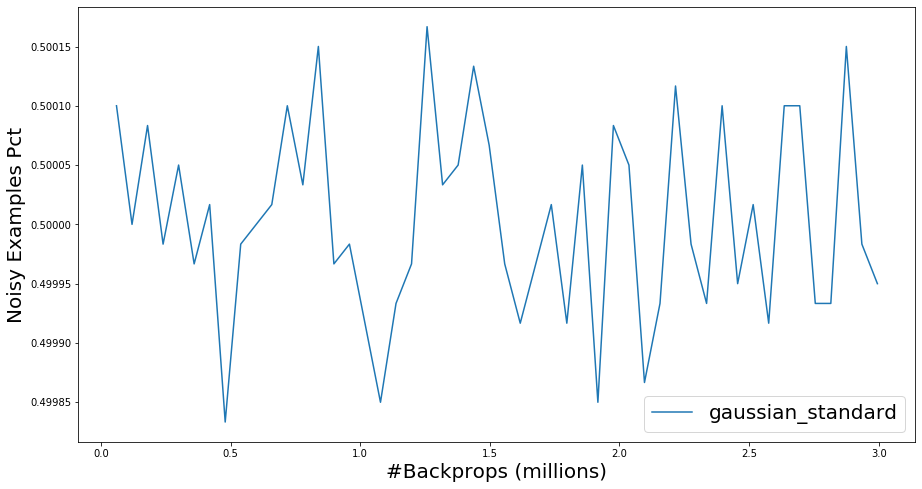

In [545]:
def count_noisy_examples(name):
    get_examples = lambda x:  [xx[0] for xx in x]
    #return [len(noise.intersection(get_examples(j)))  for i in results[dname]['train'][0]['examples'] for j in i]
    
    return [np.mean([len(noise.intersection(get_examples(j))) / 512 for j in i]) for i in results[name]['train'][0]['examples']]

def train_loss(name):
    return [np.mean([np.mean([k[1] for k in j]) for j in i]) for i in results[name]['train'][0]['examples']]


def count_noise_in_correct(name):
    return [np.mean([len(noise.intersection(j)) for j in i ]) for i in results[dname]['train'][0]['correct_pred']]

def train_pred1(name):
    return [np.mean(i) for i in results[name]['train'][0]['train_pred1']]

def noisy_loss(name):
    return [np.mean([np.mean([k[1] for k in j if k[0] in noise]) for j in i]) for i in results[name]['train'][0]['examples']]



'''fig, ax = plt.subplots(figsize=(15, 8))
for dname in directories:
    num_backprops = np.cumsum(results[dname]['train'][0]['epoch_backprops'])
    plt.plot(num_backprops, train_loss(dname))
    plt.plot(num_backprops, noisy_loss(dname))
plt.legend([1,2])   ''' 
    
    
    
fig, ax = plt.subplots(figsize=(15, 8))
for dname in directories:
    num_backprops = np.cumsum(results[dname]['train'][0]['epoch_backprops'])
    
    plt.plot(num_backprops / 1e+6, count_noisy_examples(dname))
    

ax.set_xlabel("#Backprops (millions)", size=20)
ax.set_ylabel("Noisy Examples Pct", size=20)
plt.legend(directories,  fontsize=20)



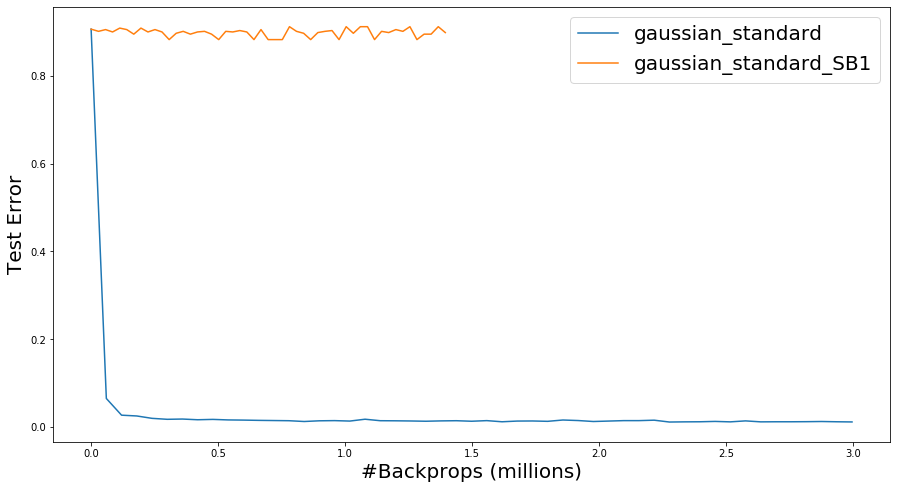

In [549]:
fig, ax = plt.subplots(figsize=(15, 8))

for dname in directories:
    num_backprops = np.cumsum([0] + results[dname]['train'][0]['epoch_backprops'])
    test_error = 1 - np.array(results[dname]['test'][0]['epoch_pred1'])
    plt.plot(num_backprops / 1e+6, test_error)

ax.set_xlabel("#Backprops (millions)", size=20)
ax.set_ylabel("Test Error", size=20)
plt.legend(directories,  fontsize=20)

#plt.legend(["Standard", "SB (beta=1)", "SB (beta=3)", "compaction, sample prob 0.1, confidence 0.8"],  fontsize=20)

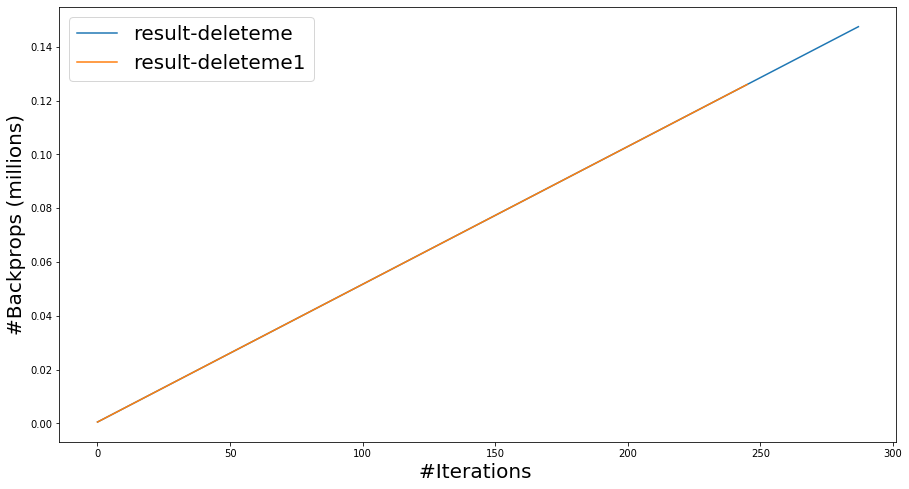

In [413]:
fig, ax = plt.subplots(figsize=(15, 8))

for dname in directories:
    plt.plot(np.cumsum(results[dname]['train'][0]['backprops']) / 1e+6)

ax.set_xlabel("#Iterations ", size=20)
ax.set_ylabel("#Backprops (millions)", size=20)
plt.legend(directories,  fontsize=20)

#plt.legend(["Standard", "SB (beta=1)", "SB (beta=3)", "compaction, sample prob 0.1, confidence 0.8"],  fontsize=20)

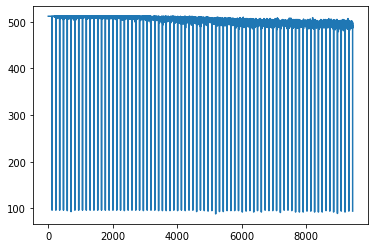

In [201]:
plt.plot(results['compaction70']['train'][0]['backprops'])

In [202]:
for dname in directories:
    num_backprops = np.cumsum(results[dname]['train'][0]['epoch_backprops'])
    test_acc = np.array(results[dname]['test'][0]['epoch_pred1'])
    print (dname, test_acc.max())

compaction 0.9812999998779297
compaction70 0.9816999998779297


ValueError: x and y must have same first dimension, but have shapes (19500,) and (50, 390)

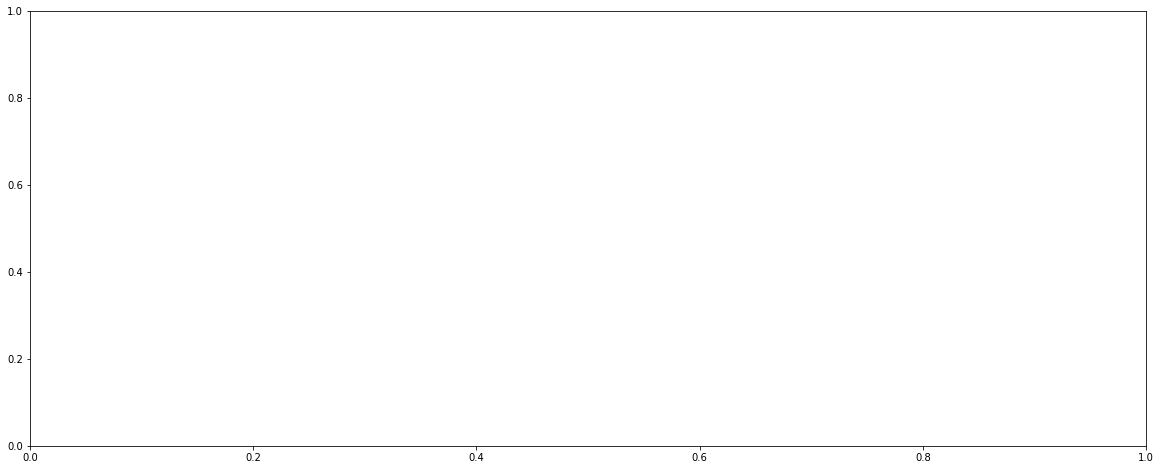

In [246]:
fig, ax = plt.subplots(figsize=(20, 8))

for dname in directories:
    num_backprops = np.cumsum(results[dname]['train'][0]['backprops'])
    plt.plot(num_backprops / 1e+6, results[dname]['train'][0]['train_loss'])


plt.legend(directories,  fontsize=20)

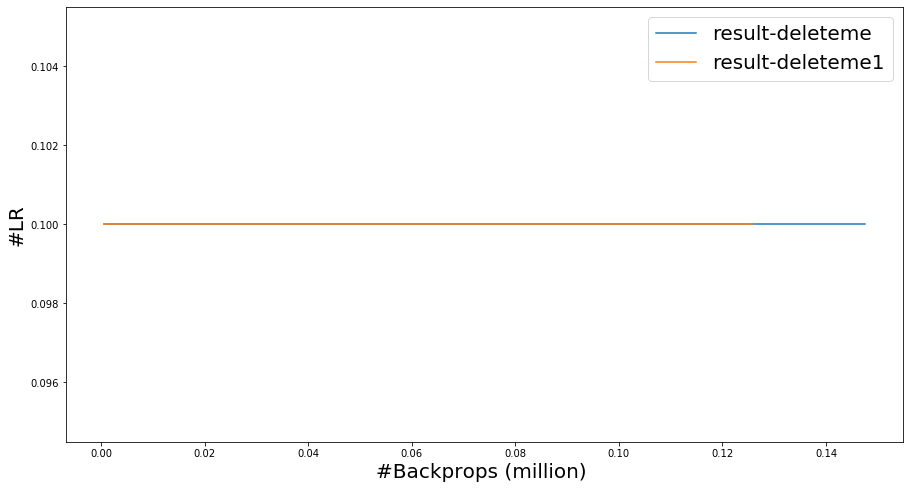

In [414]:
fig, ax = plt.subplots(figsize=(15, 8))

for dname in directories:
    plt.plot(np.cumsum(results[dname]['train'][0]['backprops']) / 1e+6, results[dname]['train'][0]['lr'])

ax.set_xlabel("#Backprops (million) ", size=20)
ax.set_ylabel("#LR", size=20)
plt.legend(directories,  fontsize=20)
#plt.legend(["Standard", "SB (beta=1)", "SB (beta=3)", "compaction, sample prob 0.1, confidence 0.8"],  fontsize=20)

# Generate Random Labels

In [455]:
def generate_random_labels(dataset, prob=0.5):
    ans = []
    classes = range(len(dataset.classes()))
    
    for j in dataset:
        if (np.random.random() < prob):
            ans += [np.random.choice(classes)]
        else:
            ans += [j[1]]
    return ans

In [507]:
from utils.cifar import IndexedCifar10
from utils.cifar100 import IndexedCifar100
from utils.mnist import IndexedMNIST


trainset = IndexedMNIST(root='./data', train=True, download=True,transform=IndexedMNIST.transform_train)

In [456]:
ans = generate_random_labels(trainset, 0.25)

In [462]:
np.mean([j[1] == ans[j[2]] for j in trainset])

0.75382

In [248]:
buf = np.load('dataset_overrides/cifar100/25pct_random_label.npy')


In [466]:
len(trainset)

10000

In [460]:
np.save("dataset_overrides/cifar100/25pct_random_label", ans)

In [388]:
buf = np.random.choice(range(len(trainset)), size=int(len(trainset) * 0.25), replace=False)

In [383]:
from analysis_utils import plot_images, show_mnist_batch, show_cifar10_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


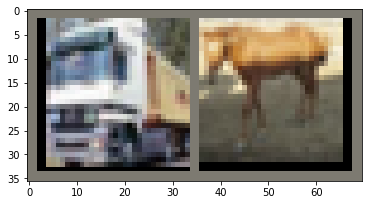

(None, 7)

In [384]:
plot_images(trainset, [1,2000], 10, show_cifar10_batch), trainset[2000][1]

In [515]:
noise = 1 * torch.randn(trainset.mnist.data.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


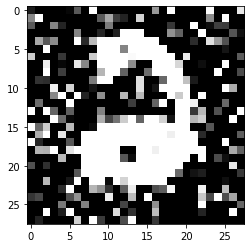

In [516]:
idx = 82
show_mnist_batch(noise[idx] + trainset[idx][0])

In [340]:
#noise[8263] + trainset[8263][0]

In [303]:
2332 in set(examples_to_add_noise)

True

In [318]:
trainset[83][0].mean()

tensor(0.0108)

In [343]:
data, target =  trainset.mnist[0]

In [352]:
(data + noise[8263].unsqueeze(0))

torch.Size([1, 28, 28])